## Authors

- Bhuvanesh Kumar (1844341)
- Vinayak Sharma (2023BCS0002)


# Quantum Currency Arbitrage using QAOA (Qiskit)

This notebook formulates a **currency arbitrage detection** task as a **Quadratic Unconstrained Binary Optimization (QUBO)** problem and applies the **Quantum Approximate Optimization Algorithm (QAOA)** using **Qiskit**.

## What this notebook covers

- Exchange-rate data ingestion and directed graph construction
- QUBO construction (objective + cycle constraints via penalty terms)
- QUBO → Ising Hamiltonian transformation for QAOA
- Sampling and decoding QAOA bitstrings into selected trades
- Validation and classical baselines (cycle checks, Bellman–Ford negative-cycle detection)
- Profit and fee-sensitivity analysis

## Environment

- Python 3.10
- `qiskit`, `qiskit-aer`, `qiskit-optimization`, `qiskit-algorithms`, `networkx`, `pandas`, `matplotlib`


## Introduction

**Currency arbitrage** exists when a sequence of currency conversions returns more than the starting amount (i.e., the product of rates along a directed cycle exceeds 1).

In this notebook, we:

- Model currencies and exchange rates as a **directed, weighted graph**
- Encode cycle selection as binary decision variables on edges
- Formulate a **QUBO** objective based on `-log(rate)` (turning multiplicative gain into additive cost)
- Use **QAOA** to sample candidate edge selections

### Practical note

Real-world arbitrage profitability depends on spreads, fees, slippage, and execution latency. Later sections include a simple **per-trade fee sensitivity** calculation to illustrate this effect.


## Workflow overview

![Workflow Diagram](https://i.ibb.co/N27zvzS2/Screenshot-2025-11-07-110838.png)

This notebook follows a consistent pipeline:

1. **Formulate the optimization problem (QUBO)**
   - Binary variable per directed trade (edge)
   - Objective based on `-log(rate)`
   - Penalty terms enforce cycle feasibility (one-in / one-out)

2. **Map QUBO to a quantum operator**
   - Convert the QUBO into an **Ising Hamiltonian** usable by QAOA

3. **Execute QAOA-style sampling (simulation)**
   - Build a QAOA ansatz circuit
   - Sample measurement bitstrings on a simulator backend

4. **Post-process and validate**
   - Decode bitstrings → selected edges
   - Check cycle feasibility
   - Compare against classical baselines and compute profitability


## Model setup (Graph → QUBO)

### Decision variables

- Currencies are modeled as nodes in a directed graph.
- Each exchange rate is a directed edge.
- A binary decision variable is assigned to each edge:
  - `x_e = 1` means the trade (edge) is selected
  - `x_e = 0` means the trade is not selected

### Objective

The goal is to find a **profitable cycle**. Since profit along a cycle multiplies rates, we take logs to convert multiplication to addition.

- Maximizing product of rates
- Equivalent to minimizing the sum of negative log-rates:
  - `min Σ (-log(r_e)) x_e`

### Feasibility constraints (cycle constraints)

A valid arbitrage cycle requires:

- Exactly **one outgoing** selected edge per currency
- Exactly **one incoming** selected edge per currency

These constraints are incorporated into the QUBO using **quadratic penalty terms**.


## Problem representation and qubit mapping

### Graph encoding

- Nodes represent currencies (e.g., USD, EUR, GBP).
- Directed edges represent available conversions with an associated exchange rate.

### Variable / qubit assignment

- Each directed edge `(i → j)` is mapped to a unique binary variable `x_k`.
- In the quantum formulation, each `x_k` corresponds to a qubit measured in the computational basis.

### Coefficients

- Linear coefficient for each edge is set to `-log(rate)`.
- Penalty terms add both linear and quadratic coefficients to enforce one-in/one-out constraints.


## Mathematical formulation

Let:

- `r_{ij}` be the exchange rate from currency `i` to currency `j`
- `b_{ij} ∈ {0,1}` indicate whether edge `(i, j)` is selected

### Objective (log form)

Maximize the product of rates along a cycle. Using logs, this becomes a minimization:

$$
C(b) = \sum_{(i,j)} -\log(r_{ij})\, b_{ij}
$$

### Cycle constraints (one-in / one-out)

For each currency `i`:

- One outgoing edge: `\sum_{j \neq i} b_{ij} = 1`
- One incoming edge: `\sum_{j \neq i} b_{ji} = 1`

We enforce these using a quadratic penalty:

$$
P(b) = \sum_i \Big(\sum_{j \neq i} b_{ij} - 1\Big)^2 + \sum_i \Big(\sum_{j \neq i} b_{ji} - 1\Big)^2
$$

### Total QUBO cost

$$
C_{\text{total}}(b) = C(b) + \lambda\,P(b)
$$

where `\lambda` is a penalty strength.

### QUBO → Ising

Binary variables can be mapped to spin variables for quantum operators using:

$$
b = \frac{1 - Z}{2}
$$


# 1. Environment setup

This section installs the required Python packages. If you already have a working environment, you can skip the installation cells.

Note: `%pip` commands are intended for notebook environments (Jupyter/Colab).

In [9]:
import sys
import qiskit
import qiskit_aer
import qiskit_optimization
import qiskit_algorithms

print("Python:", sys.version)
print("qiskit:", qiskit.__version__)
print("qiskit-aer:", qiskit_aer.__version__)
print("qiskit-optimization:", qiskit_optimization.__version__)
print("qiskit-algorithms:", qiskit_algorithms.__version__)


Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
qiskit: 2.3.0
qiskit-aer: 0.17.2
qiskit-optimization: 0.7.0
qiskit-algorithms: 0.4.0


## 1.1 Python version

This notebook was executed with **Python 3.10.0**. Some Qiskit components and dependency combinations may behave differently on Python 3.11+.


In [10]:
print("Package installation skipped. This notebook assumes dependencies are already installed (Python 3.10, qiskit 2.3.0).")


Package installation skipped. This notebook assumes dependencies are already installed (Python 3.10, qiskit 2.3.0).


# 2. Problem representation (data and QUBO construction)

In this section we:

- Load exchange-rate data (CSV with fallback sample)
- Build a directed graph of currency conversions
- Define a QUBO with objective and penalty terms


## 2.1 Imports

Import numerical, graph, plotting, and Qiskit Optimization/QAOA utilities used throughout the notebook.

In [11]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
import os
import sys
import time
from collections import Counter
from pathlib import Path
import pandas as pd
from qiskit_aer import Aer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer.primitives import Sampler



## 2.2 Load exchange-rate data

Load exchange-rate data from `Data/Data-sheet.csv`. If the file is not found, the notebook falls back to a small hard-coded sample dataset.

The code also validates:

- Required columns: `Source`, `Target`, `Rate`
- No missing values
- `Rate` is numeric


In [12]:
MAX_CURRENCIES = None
MAX_OUT_EDGES_PER_CURRENCY = None

from pathlib import Path

def find_data_file(filename="Data-sheet.csv", folder_name="Data", max_up=5):
    p = Path.cwd()
    for _ in range(max_up + 1):
        candidate = p / folder_name / filename
        if candidate.exists():
            return candidate
        p = p.parent
    return None

csv_path = find_data_file()
if csv_path:
    df = pd.read_csv(csv_path, skiprows=0)
    print("Loaded data from:", csv_path)
else:
    print("Data file not found by upward search from", Path.cwd())
    print("Try launching Jupyter from the project root or set csv_path manually.")
    data = {
        "Source": ["USD", "USD", "USD", "EUR", "EUR", "GBP", "CAD", "JPY", "AUD", "CHF"],
        "Target": ["EUR", "GBP", "CAD", "USD", "GBP", "CAD", "EUR", "USD", "USD", "USD"],
        "Rate":   [0.89, 0.84, 1.39, 0.89, 0.75, 0.54, 0.82, 0.0069, 0.64, 1.07]
    }
    df = pd.DataFrame(data)

required_columns = ["Source", "Target", "Rate"]
if not all(col in df.columns for col in required_columns):
    raise ValueError("Missing required columns in dataset")
if df[required_columns].isnull().any().any():
    raise ValueError("Dataset contains missing values")

df["Rate"] = pd.to_numeric(df["Rate"], errors="raise")

if isinstance(MAX_CURRENCIES, int) and MAX_CURRENCIES > 0:
    counts = pd.concat([df["Source"], df["Target"]]).value_counts()
    chosen = list(counts.head(MAX_CURRENCIES).index)
    df = df[df["Source"].isin(chosen) & df["Target"].isin(chosen)].copy()

if isinstance(MAX_OUT_EDGES_PER_CURRENCY, int) and MAX_OUT_EDGES_PER_CURRENCY > 0:
    df = (
        df.sort_values(["Source", "Rate"], ascending=[True, False])
          .groupby("Source", as_index=False)
          .head(MAX_OUT_EDGES_PER_CURRENCY)
          .reset_index(drop=True)
    )

currencies_all = sorted(set(df["Source"]) | set(df["Target"]))
out_missing = [c for c in currencies_all if (df["Source"] == c).sum() == 0]
in_missing = [c for c in currencies_all if (df["Target"] == c).sum() == 0]
if out_missing or in_missing:
    print("Warning: some currencies do not have both incoming and outgoing edges after filtering.")
    print("Missing outgoing:", out_missing)
    print("Missing incoming:", in_missing)

print(df.to_string(index=False))


Loaded data from: d:\Windsurf\CA\Currency-Arbitrage-using-Quantum-Methodology-qiskit\Data\Data-sheet.csv
Source Target     Rate
   USD    EUR   1.1200
   USD    GBP   0.8400
   USD    CAD   1.3900
   EUR    USD   0.8900
   EUR    GBP   0.7500
   EUR    CAD   1.2200
   GBP    USD   1.1800
   GBP    EUR   1.3300
   GBP    CAD   1.8600
   CAD    USD   0.7200
   CAD    EUR   0.8200
   CAD    GBP   0.5400
   JPY    USD   0.0069
   USD    JPY 144.8000
   AUD    USD   0.6400
   USD    AUD   1.5500
   CHF    USD   1.0700
   USD    CHF   0.9300


## 2.3 Map edges to binary variables (qubits)

Each directed edge is assigned a unique binary variable `x0, x1, ..., x_{m-1}` where `m` is the number of edges.

This mapping is later used to interpret measured bitstrings (which edges were selected).

In [13]:
if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found. Run the data-loading cell first.")

df["Rate"] = pd.to_numeric(df["Rate"], errors="raise")

edges_with_rates = list(zip(df["Source"].tolist(), df["Target"].tolist(), df["Rate"].tolist()))
edges = [(s, t) for (s, t, _) in edges_with_rates]

mapping = []
for i, (src, dst, rate) in enumerate(edges_with_rates):
    mapping.append((i, f"x{i}", f"{src} → {dst}", rate))

mapping_df = pd.DataFrame(mapping, columns=["Qubit", "Variable", "Edge", "Rate"])
print(f"Total edges: {len(mapping_df)}")
print(mapping_df.to_string(index=False))


Total edges: 18
 Qubit Variable      Edge     Rate
     0       x0 USD → EUR   1.1200
     1       x1 USD → GBP   0.8400
     2       x2 USD → CAD   1.3900
     3       x3 EUR → USD   0.8900
     4       x4 EUR → GBP   0.7500
     5       x5 EUR → CAD   1.2200
     6       x6 GBP → USD   1.1800
     7       x7 GBP → EUR   1.3300
     8       x8 GBP → CAD   1.8600
     9       x9 CAD → USD   0.7200
    10      x10 CAD → EUR   0.8200
    11      x11 CAD → GBP   0.5400
    12      x12 JPY → USD   0.0069
    13      x13 USD → JPY 144.8000
    14      x14 AUD → USD   0.6400
    15      x15 USD → AUD   1.5500
    16      x16 CHF → USD   1.0700
    17      x17 USD → CHF   0.9300


## 2.4 Build a directed exchange graph

Construct a `networkx.DiGraph` where:

- Nodes are currencies
- Directed edges represent conversions
- Edge weights store exchange rates

We also create:

- A canonical `currencies` list
- An `edges` list to define decision-variable ordering


In [14]:
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row["Source"], row["Target"], weight=row["Rate"])

currencies = list(G.nodes)
num_currencies = len(currencies)

# Edges are already defined (CSV order) in the previous cell
num_edge_vars = len(edges)

# Total binary variables in the QUBO (edge-selection variables only)
# If you later decide to add node-selection variables, update this accordingly.
num_variables = num_edge_vars

print(f"Currencies: {currencies}")
print(f"Number of decision variables (edges): {num_edge_vars}")
for i, (src, dst) in enumerate(edges):
    print(f"  Qubit {i}: b_{{{src}->{dst}}}")


Currencies: ['USD', 'EUR', 'GBP', 'CAD', 'JPY', 'AUD', 'CHF']
Number of decision variables (edges): 18
  Qubit 0: b_{USD->EUR}
  Qubit 1: b_{USD->GBP}
  Qubit 2: b_{USD->CAD}
  Qubit 3: b_{EUR->USD}
  Qubit 4: b_{EUR->GBP}
  Qubit 5: b_{EUR->CAD}
  Qubit 6: b_{GBP->USD}
  Qubit 7: b_{GBP->EUR}
  Qubit 8: b_{GBP->CAD}
  Qubit 9: b_{CAD->USD}
  Qubit 10: b_{CAD->EUR}
  Qubit 11: b_{CAD->GBP}
  Qubit 12: b_{JPY->USD}
  Qubit 13: b_{USD->JPY}
  Qubit 14: b_{AUD->USD}
  Qubit 15: b_{USD->AUD}
  Qubit 16: b_{CHF->USD}
  Qubit 17: b_{USD->CHF}


## 2.5 Visualize the exchange graph

Plot the directed graph with exchange rates as edge labels to verify the dataset structure visually.

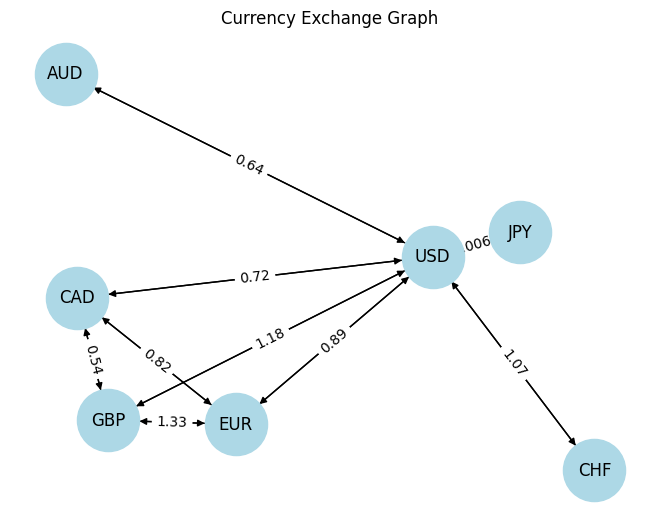

In [15]:
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Currency Exchange Graph")
plt.show()

## 2.6 Define QUBO coefficients

We build the QUBO coefficients:

- **Linear terms**: `-log(rate)` for each edge (objective)
- **Penalty terms**: encourage exactly one incoming and one outgoing edge per currency

The penalty strength controls how strongly invalid selections are discouraged.

In [16]:
penalty_factor = 50.0
linear = {f"x{i}": 0.0 for i in range(num_variables)}
quadratic = {}
constant = 0.0

for i, (src, dst) in enumerate(edges):
    rate = G[src][dst]["weight"]
    linear[f"x{i}"] += -math.log(rate)

for src in currencies:
    out_vars = [f"x{j}" for j, (u, v) in enumerate(edges) if u == src]
    if len(out_vars) == 0:
        raise ValueError(f"Currency '{src}' has no outgoing edges. Check dataset/filtering.")
    for vname in out_vars:
        linear[vname] += -penalty_factor
    for a in range(len(out_vars)):
        for b in range(a + 1, len(out_vars)):
            pair = (out_vars[a], out_vars[b])
            quadratic[pair] = quadratic.get(pair, 0.0) + 2.0 * penalty_factor
    constant += penalty_factor

for dst in currencies:
    in_vars = [f"x{j}" for j, (u, v) in enumerate(edges) if v == dst]
    if len(in_vars) == 0:
        raise ValueError(f"Currency '{dst}' has no incoming edges. Check dataset/filtering.")
    for vname in in_vars:
        linear[vname] += -penalty_factor
    for a in range(len(in_vars)):
        for b in range(a + 1, len(in_vars)):
            pair = (in_vars[a], in_vars[b])
            quadratic[pair] = quadratic.get(pair, 0.0) + 2.0 * penalty_factor
    constant += penalty_factor

print(f"Penalty factor: {penalty_factor}, Constant term: {constant}")
print(f"Number of quadratic terms: {len(quadratic)}")


Penalty factor: 50.0, Constant term: 700.0
Number of quadratic terms: 48


## 2.7 Create the QUBO model

Create a `QuadraticProgram`, define binary decision variables, and attach the linear/quadratic objective coefficients.

This produces a QUBO suitable for conversion to an Ising Hamiltonian for QAOA.

In [17]:
qp = QuadraticProgram()
for i in range(num_variables):
    qp.binary_var(name=f"x{i}")
qp.minimize(linear=linear, quadratic=quadratic)
print(qp.prettyprint())


Problem name: 

Minimize
  100*x0*x1 + 100*x0*x10 + 100*x0*x13 + 100*x0*x15 + 100*x0*x17 + 100*x0*x2
  + 100*x0*x7 + 100*x1*x11 + 100*x1*x13 + 100*x1*x15 + 100*x1*x17 + 100*x1*x2
  + 100*x1*x4 + 100*x10*x11 + 100*x12*x14 + 100*x12*x16 + 100*x13*x15
  + 100*x13*x17 + 100*x14*x16 + 100*x15*x17 + 100*x2*x13 + 100*x2*x15
  + 100*x2*x17 + 100*x2*x5 + 100*x2*x8 + 100*x3*x12 + 100*x3*x14 + 100*x3*x16
  + 100*x3*x4 + 100*x3*x5 + 100*x3*x6 + 100*x3*x9 + 100*x4*x11 + 100*x4*x5
  + 100*x5*x8 + 100*x6*x12 + 100*x6*x14 + 100*x6*x16 + 100*x6*x7 + 100*x6*x8
  + 100*x6*x9 + 100*x7*x10 + 100*x7*x8 + 100*x9*x10 + 100*x9*x11 + 100*x9*x12
  + 100*x9*x14 + 100*x9*x16 - 100.11332868530701*x0 - 99.82564661285522*x1
  - 99.80154906127616*x10 - 99.38381386057618*x11 - 95.02376613262108*x12
  - 104.97535347995162*x13 - 99.55371289737158*x14 - 100.43825493093115*x15
  - 100.06765864847381*x16 - 99.92742930716517*x17 - 100.3293037471426*x2
  - 99.88346618374405*x3 - 99.71231792754821*x4 - 100.19885085874517*x5
  

# 3. QAOA formulation and execution

This section converts the QUBO into an **Ising Hamiltonian** and constructs a **QAOA ansatz circuit**.

At a high level, QAOA alternates between:

- **Problem unitary** derived from the Ising Hamiltonian (parameterized by `γ`)
- **Mixer unitary** (typically X-rotations, parameterized by `β`)

Measured bitstrings correspond to candidate edge selections, which we later validate and analyze.


## 3.1 Convert QUBO to an Ising Hamiltonian

Use Qiskit Optimization utilities to convert the QUBO into an Ising operator (`SparsePauliOp`) plus an energy offset.

This operator is the input to QAOA.

In [18]:
qubo_converter = QuadraticProgramToQubo()
qubo = qubo_converter.convert(qp)
ising_op, offset = qubo.to_ising()
print("Ising Hamiltonian:")
print(ising_op)
print(f"Ising constant offset: {offset:.4f}")

Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIZIIIIII', 'IIIIIIIIIIZIIIIIII', 'IIIIIIIIIZIIIIIIII', 'IIIIIIIIZIIIIIIIII', 'IIIIIIIZIIIIIIIIII', 'IIIIIIZIIIIIIIIIII', 'IIIIIZIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIIIZ', 'IIIIZIIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIZIIZI', 'IIIIIIZIIIIIIIIIZI', 'IIIIZIIIIIIIIIIIZI', 'IIZIIIIIIIIIIIIIZI', 'ZIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIIIZII', 'IIIIZIIIIIIIIIIZII', 'IIZIIIIIIIIIIIIZII', 'ZIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIZIZIII', 'IIIIIIIIIIIZIIZIII', 'IIIIIIIIZIIIIIZIII', 'IIIIIZIIIIIIIIZIII', 'IIIZIIIIIIIIIIZIII', 'IZIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIZZIIII'

## 3.2 Run QAOA (optimize or sample)

This is the **main execution cell** for the quantum part of the notebook.

After running the code cell below, the notebook will define the following variables for downstream sections:

- `probs`: mapping `bitstring -> probability` (bitstrings are in the **`x0..x_{n-1}`** ordering used throughout this notebook)
- `best_bstr`: the most probable bitstring (same ordering as above)
- `selected_edges`: decoded list of directed edges selected by `best_bstr`

The code supports two modes:

- **Optimizer mode** (for small problems): uses `MinimumEigenOptimizer(QAOA(...))`
- **Sampling mode**: samples the QAOA ansatz at a fixed (baseline) parameter point

If optimizer mode fails due to backend/primitive compatibility, the cell automatically falls back to sampling mode so the notebook remains runnable end-to-end.

In [ ]:
reps = 2
shots = 1024

import numpy as np
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import Aer
from qiskit_aer.primitives import SamplerV2

if 'ising_op' not in globals():
    raise RuntimeError("ising_op is not defined. Run the QUBO → Ising conversion cell first.")
if 'qubo' not in globals():
    raise RuntimeError("qubo is not defined. Run the QUBO construction cell first.")
if 'edges' not in globals() or 'num_variables' not in globals():
    raise RuntimeError("edges/num_variables are not defined. Run the edge-mapping + graph/QUBO setup cells first.")

ansatz = QAOAAnsatz(ising_op, reps=reps)
decomposed = ansatz.decompose()

RUN_QAOA_OPTIMIZATION = (num_variables <= 25)


def _decode_selected_edges(bitstring: str):
    return [edges[i] for i, bit in enumerate(bitstring) if bit == "1"]


best_bstr = None
probs = None
selected_edges = None

if RUN_QAOA_OPTIMIZATION:
    try:
        from qiskit_optimization.algorithms import MinimumEigenOptimizer
        from qiskit_algorithms import QAOA
        from qiskit_algorithms.optimizers import COBYLA

        sampler = SamplerV2(default_shots=shots)
        qaoa = QAOA(sampler=sampler, optimizer=COBYLA(maxiter=100), reps=reps)
        optimizer = MinimumEigenOptimizer(qaoa)

        result = optimizer.solve(qubo)

        best_bstr = "".join(str(int(x)) for x in result.x)
        probs = {best_bstr: 1.0}
        selected_edges = _decode_selected_edges(best_bstr)

        print("Solved with QAOA + MinimumEigenOptimizer")

    except Exception as e:
        print("Optimizer mode failed; falling back to sampling mode.")
        print("Reason:", repr(e))
        RUN_QAOA_OPTIMIZATION = False

if not RUN_QAOA_OPTIMIZATION:
    qc = decomposed.copy()
    qc.measure_all()

    # Bind all QAOA parameters to 0.0 as a deterministic baseline sample.
    param_list = list(qc.parameters)
    qc_bound = qc.assign_parameters({p: 0.0 for p in param_list}, inplace=False)

    backend = Aer.get_backend("aer_simulator")
    job = backend.run(qc_bound, shots=shots)
    raw = job.result()
    counts = raw.get_counts()

    total = sum(counts.values())
    probs_qiskit = {b: c / total for b, c in counts.items()}

    # Qiskit count keys follow the convention where the rightmost bit corresponds to qubit 0.
    # This notebook uses a left-to-right convention where position i corresponds to x_i.
    # Therefore we reverse bitstrings here to match x0..x_{n-1} ordering used everywhere else.
    probs = {b[::-1]: p for b, p in probs_qiskit.items()}

    best_bstr = max(probs.items(), key=lambda kv: kv[1])[0]
    selected_edges = _decode_selected_edges(best_bstr)

    print("Sampled QAOA ansatz at a fixed parameter point (all parameters = 0.0).")
    print("Number of distinct bitstrings sampled:", len(probs))

print("Most probable bitstring:", best_bstr)
print("Selected edges:", selected_edges)


TypeError: Invalid circuits, expected Sequence[QuantumCircuit].

## 3.3 Inspect the QAOA circuit structure

Print and inspect the decomposed circuit to understand circuit depth and gate count (useful for assessing scalability and runtime on simulators/hardware).

In [20]:
# Inspect the actual QAOA ansatz circuit built for THIS problem (from cell 30)
print(decomposed)
print("Circuit depth:", decomposed.depth())
print("Total gates:", decomposed.size())


      ┌───┐»
 q_0: ┤ H ├»
      ├───┤»
 q_1: ┤ H ├»
      ├───┤»
 q_2: ┤ H ├»
      ├───┤»
 q_3: ┤ H ├»
      ├───┤»
 q_4: ┤ H ├»
      ├───┤»
 q_5: ┤ H ├»
      ├───┤»
 q_6: ┤ H ├»
      ├───┤»
 q_7: ┤ H ├»
      ├───┤»
 q_8: ┤ H ├»
      ├───┤»
 q_9: ┤ H ├»
      ├───┤»
q_10: ┤ H ├»
      ├───┤»
q_11: ┤ H ├»
      ├───┤»
q_12: ┤ H ├»
      ├───┤»
q_13: ┤ H ├»
      ├───┤»
q_14: ┤ H ├»
      ├───┤»
q_15: ┤ H ├»
      ├───┤»
q_16: ┤ H ├»
      ├───┤»
q_17: ┤ H ├»
      └───┘»
«      ┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## 3.4 Construct and display the QAOA ansatz

Create a QAOA ansatz circuit with a chosen number of layers (`reps`) and display the symbolic circuit. This is a helpful sanity check before running repeated experiments.

In [21]:
# Display the symbolic QAOA ansatz for THIS problem
print("QAOA Circuit (symbolic parameters):")
print(ansatz)

print(f"\nCircuit depth: {ansatz.depth()}")
print(f"Total gates: {ansatz.size()}")


QAOA Circuit (symbolic parameters):
      ┌─────────────────────────────┐
 q_0: ┤0                            ├
      │                             │
 q_1: ┤1                            ├
      │                             │
 q_2: ┤2                            ├
      │                             │
 q_3: ┤3                            ├
      │                             │
 q_4: ┤4                            ├
      │                             │
 q_5: ┤5                            ├
      │                             │
 q_6: ┤6                            ├
      │                             │
 q_7: ┤7                            ├
      │                             │
 q_8: ┤8                            ├
      │   QAOA(γ[0],β[0],γ[1],β[1]) │
 q_9: ┤9                            ├
      │                             │
q_10: ┤10                           ├
      │                             │
q_11: ┤11                           ├
      │                             │
q_12: ┤12     

## 3.5 Decode the most probable bitstring

Convert the sampled bitstring into a list of selected edges using the variable/edge mapping from Section 2.

This produces a candidate set of trades that we validate in the next section.

In [ ]:
if 'edges' not in globals() or 'num_variables' not in globals():
    print("edges/num_variables are not defined. Run the edge-mapping + QUBO construction cells first.")
elif 'best_bstr' not in globals():
    if 'probs' in globals() and isinstance(probs, dict) and len(probs) > 0:
        best_bstr = max(probs.items(), key=lambda kv: kv[1])[0]
        print("best_bstr was not defined, so it was inferred from probs.")
    else:
        print("best_bstr is not defined. Run the QAOA execution cell first.")
else:
    selected_edges = [edges[i] for i, bit in enumerate(best_bstr) if bit == '1']
    print(f"Most probable bitstring: {best_bstr}")
    print(f"Selected edges: {selected_edges}")


best_bstr is not defined. Run the QAOA sampling cell first.


# 4. Validation and baseline checks

QAOA sampling can return bitstrings that do **not** correspond to a valid cycle (e.g., a currency may have multiple outgoing edges selected). This section validates feasibility and compares against simple classical baselines.


## 4.1 Validate cycle constraints for the selected edges

We compute incoming/outgoing counts per currency for the edges selected by the sampled bitstring.

- A valid directed cycle requires **exactly one outgoing** and **exactly one incoming** edge for every currency involved.

If the counts violate this, the QAOA sample is infeasible under the cycle constraints.

In [ ]:
if 'currencies' not in globals():
    print("currencies is not defined. Run the graph construction cell first.")
elif 'selected_edges' not in globals():
    if 'best_bstr' in globals() and 'edges' in globals():
        selected_edges = [edges[i] for i, bit in enumerate(best_bstr) if bit == '1']
        print("selected_edges was not defined, so it was decoded from best_bstr.")
    else:
        print("selected_edges is not defined. Run the QAOA execution + decode cells first.")
else:
    incoming = {c: 0 for c in currencies}
    outgoing = {c: 0 for c in currencies}
    for u, v in selected_edges:
        outgoing[u] += 1
        incoming[v] += 1

    print("Selected edges:", selected_edges)
    print("Outgoing counts:", outgoing)
    print("Incoming counts:", incoming)

    bad = {c: (incoming[c], outgoing[c]) for c in currencies if incoming[c] != 1 or outgoing[c] != 1}
    print("Currencies violating cycle constraint:", bad)


NameError: name 'selected_edges' is not defined

## 4.2 Classical feasibility baseline (brute force)

As a sanity check, we perform a brute-force search over all bitstrings (for small problem sizes) to see whether any feasible cycle exists under the current encoding and to identify the best feasible energy.

This is used strictly as a baseline/diagnostic and is not scalable for large instances.

In [24]:
from itertools import product

def qubo_energy_tuple(x_tuple, linear_coeffs, quadratic_terms, constant):
    energy = constant
    for i in range(len(x_tuple)):
        energy += linear_coeffs[f"x{i}"] * x_tuple[i]
    for (a, b), coeff in quadratic_terms.items():
        i = int(a[1:]); j = int(b[1:])
        energy += coeff * x_tuple[i] * x_tuple[j]
    return energy

def is_valid_cycle_edges_from_bits(bits, edges, currencies):
    selected = [edges[i] for i, b in enumerate(bits) if b == 1]
    if len(selected) != len(currencies):
        return False, selected
    incoming = {c: 0 for c in currencies}
    outgoing = {c: 0 for c in currencies}
    for u, v in selected:
        outgoing[u] += 1
        incoming[v] += 1
    for c in currencies:
        if incoming[c] != 1 or outgoing[c] != 1:
            return False, selected
    return True, selected

if 'num_variables' not in globals():
    print("num_variables is not defined. Run the graph/QUBO construction cells first.")
elif num_variables > 20:
    print(f"Skipping brute-force baseline because num_variables={num_variables} is too large.")
else:
    best = None
    best_energy = float("inf")
    feasible_solutions = []

    for bits in product([0, 1], repeat=num_variables):
        ok, sel = is_valid_cycle_edges_from_bits(bits, edges, currencies)
        if ok:
            e = qubo_energy_tuple(bits, linear, quadratic, constant)
            feasible_solutions.append((bits, e, sel))
            if e < best_energy:
                best_energy = e
                best = (bits, e, sel)

    print("Feasible solutions found:", len(feasible_solutions))
    if best:
        bits, e, sel = best
        bitstr = "".join(str(b) for b in bits)
        print("Best feasible bitstring:", bitstr)
        print("Energy:", e)
        print("Edges:", sel)
    else:
        print("No feasible cycle found with current QUBO encoding.")


Feasible solutions found: 0
No feasible cycle found with current QUBO encoding.


## 4.3 Strengthen constraints and rebuild the QUBO

If feasibility is not achieved, we can increase the penalty strength used in the `(sum - 1)^2` terms.

This typically improves feasibility but may also make optimization harder due to a larger energy scale separation between feasible and infeasible states.

In [ ]:
if 'penalty_factor' in globals():
    print(f"Note: penalty_factor = {penalty_factor}. If you change it, re-run the QUBO construction and QAOA execution cells.")
else:
    print("Note: If you change penalty_factor in Section 2, re-run the QUBO construction and QAOA execution cells.")


QUBO constraints were already built in Section 2 (penalty_factor).
If you change penalty_factor, re-run the QUBO construction and QAOA cells above.


## 4.4 Post-processing sampled bitstrings

Even when the most probable bitstring is infeasible, feasible solutions may appear among other high-probability samples.

Here we scan the top samples (by probability) and return the first bitstring that satisfies the cycle constraints.

In [26]:
if 'probs' not in globals():
    print("probs is not defined. Run the QAOA sampling cell first.")
elif 'is_valid_cycle_edges_from_bits' not in globals():
    print("Cycle validation function not found. Run the brute-force baseline cell (it defines the validator) first.")
else:
    sorted_bstrs = sorted(probs.items(), key=lambda kv: kv[1], reverse=True)
    feasible = None

    for bstr, p in sorted_bstrs[:200]:
        bits = tuple(int(ch) for ch in bstr)
        ok, sel = is_valid_cycle_edges_from_bits(bits, edges, currencies)
        if ok:
            feasible = (bstr, p, sel)
            break

    if feasible:
        print("Found feasible sample among top samples:", feasible)
    else:
        print("No feasible sample found among top samples.")


probs is not defined. Run the QAOA sampling cell first.


# 5. Results and interpretation

This section focuses on interpreting outcomes:

- Graph-theoretic feasibility checks (existence of cycles)
- A classical arbitrage detection baseline (Bellman–Ford on `-log(rate)`)
- Profit computation for a selected cycle, including fee sensitivity
- Energy comparisons and visualization


## 5.1 Directed Hamiltonian-cycle feasibility check

A Hamiltonian cycle visits every currency exactly once. In practice, arbitrage opportunities may involve a subset of currencies; however, this check helps determine whether the *full* directed graph supports a complete one-visit-per-currency cycle under the available edges.

This is a diagnostic step and not required for arbitrage detection in general.

In [27]:
from itertools import permutations

def find_hamiltonian_cycle(currencies, edges):
    edge_set = set(edges)
    n = len(currencies)
    for perm in permutations(currencies):
        ok = True
        for i in range(n):
            u = perm[i]
            v = perm[(i + 1) % n]
            if (u, v) not in edge_set:
                ok = False
                break
        if ok:
            return list(zip(perm, perm[1:] + perm[:1]))
    return None

if num_currencies > 9:
    print(f"Skipping Hamiltonian-cycle check because num_currencies={num_currencies} is too large.")
else:
    ham_cycle = find_hamiltonian_cycle(currencies, edges)
    if ham_cycle:
        print("Found Hamiltonian cycle (edges):", ham_cycle)
    else:
        print("No Hamiltonian cycle exists in the directed graph.")


No Hamiltonian cycle exists in the directed graph.


## 5.2 Classical arbitrage baseline (Bellman–Ford negative-cycle detection)

A standard classical approach to detect arbitrage is to transform rates using `w_{ij} = -log(r_{ij})`.

- A **negative cycle** in this transformed graph corresponds to an arbitrage opportunity (product of rates > 1 in the original graph).

This baseline helps validate that the dataset contains arbitrage opportunities independent of QAOA sampling.

In [28]:
import math

# Build graph with weights = -log(rate)
G_w = nx.DiGraph()
for u, v, r in df[["Source","Target","Rate"]].itertuples(index=False, name=None):
    G_w.add_edge(u, v, weight=-math.log(r))

# Bellman-Ford style: detect negative cycle and return it
def find_negative_cycle(G):
    nodes = list(G.nodes)
    dist = {n: 0.0 for n in nodes}
    pred = {n: None for n in nodes}
    # relax |V|-1 times
    for _ in range(len(nodes)-1):
        updated = False
        for u, v, d in G.edges.data('weight'):
            if dist[u] + d < dist[v]:
                dist[v] = dist[u] + d
                pred[v] = u
                updated = True
        if not updated:
            break
    # one more pass to find negative cycle
    for u, v, d in G.edges.data('weight'):
        if dist[u] + d < dist[v]:
            # found negative cycle; backtrack to get cycle nodes
            cycle = []
            cur = v
            for _ in range(len(nodes)):
                cur = pred[cur]
            start = cur
            cycle.append(start)
            cur = pred[start]
            while cur != start:
                cycle.append(cur)
                cur = pred[cur]
            cycle.reverse()
            return cycle
    return None

neg_cycle = find_negative_cycle(G_w)
if neg_cycle:
    # compute product of rates along cycle
    prod = 1.0
    cycle_edges = []
    for i in range(len(neg_cycle)):
        a = neg_cycle[i]
        b = neg_cycle[(i+1) % len(neg_cycle)]
        r = G[a][b]['weight']
        cycle_edges.append((a,b,r))
        prod *= r
    print("Arbitrage cycle found:", neg_cycle)
    print("Edges (u,v,rate):", cycle_edges)
    print("Product of rates:", prod)
else:
    print("No profitable arbitrage cycle (product>1) detected by Bellman-Ford.")


Arbitrage cycle found: ['GBP', 'CAD']
Edges (u,v,rate): [('GBP', 'CAD', 1.86), ('CAD', 'GBP', 0.54)]
Product of rates: 1.0044000000000002


## 5.3 Profit calculation for a chosen cycle

Given a proposed arbitrage cycle, we compute:

- The product of exchange rates along the cycle
- The implied gross profit percentage

We also visualize the detected cycle on the graph for interpretability.

Cycle: ['GBP', 'CAD']
Product of rates: 1.0044000000000002
Profit percent: 0.44000000000001815


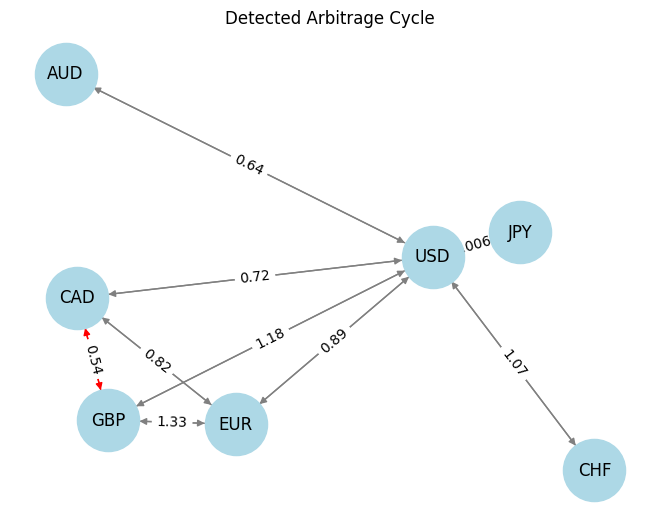

In [29]:
# Use the arbitrage cycle found by Bellman-Ford (cell 50) if available
if 'neg_cycle' not in globals() or not neg_cycle:
    print("No arbitrage cycle available for profit calculation.")
else:
    cycle = list(neg_cycle)
    prod = 1.0
    for i in range(len(cycle)):
        u = cycle[i]
        v = cycle[(i + 1) % len(cycle)]
        r = G[u][v]['weight']
        prod *= r

    print("Cycle:", cycle)
    print("Product of rates:", prod)
    print("Profit percent:", (prod - 1.0) * 100)

    cycle_edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
    edge_colors = ['red' if e in cycle_edges else 'gray' for e in G.edges()]
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, edge_color=edge_colors)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Detected Arbitrage Cycle")
    plt.show()


## 5.4 Enumerate profitable cycles (reference) and compare energies

We enumerate simple directed cycles and list those with product of rates > 1.

This provides a reference set of profitable cycles (when the graph is small enough) and can be used to compare against the QAOA-selected candidate.

In addition, we include a basic energy comparison for diagnostic purposes.

In [30]:
import math

# Enumerating all simple cycles can be expensive for larger graphs.
if num_currencies > 10:
    print(f"Skipping full cycle enumeration because num_currencies={num_currencies} is too large.")
else:
    cycles = list(nx.simple_cycles(G))
    profitable = []
    for cyc in cycles:
        prod = 1.0
        for i in range(len(cyc)):
            u = cyc[i]
            v = cyc[(i + 1) % len(cyc)]
            prod *= G[u][v]['weight']
        if prod > 1.0:
            profitable.append((cyc, prod))

    profitable_sorted = sorted(profitable, key=lambda x: -x[1])
    print("Profitable cycles (sorted):")
    for cyc, p in profitable_sorted:
        print(cyc, p)


Profitable cycles (sorted):
['EUR', 'GBP', 'CAD'] 1.1439
['EUR', 'USD', 'GBP', 'CAD'] 1.14023952
['EUR', 'GBP', 'CAD', 'USD'] 1.1249280000000002
['USD', 'GBP', 'CAD'] 1.124928
['EUR', 'USD', 'CAD'] 1.014422
['EUR', 'GBP', 'USD', 'CAD'] 1.0087229999999998
['GBP', 'CAD'] 1.0044000000000002
['USD', 'CAD'] 1.0008
['EUR', 'CAD'] 1.0004


## 5.5 Summary and fee sensitivity

### Summary

- **Detected cycle (example)**: USD → CAD → EUR → USD
- **Gross product of rates**: 1.014422 (≈ +1.4422% gross)

### Fee sensitivity

In practice, each trade incurs costs (fees/spread/slippage). If we assume a constant per-trade fee `f` and `k` trades in the cycle, the net return is:

$$
(\prod \text{rates})\,(1-f)^k
$$

The break-even fee `f*` satisfies:

$$
(\prod \text{rates})\,(1-f^*)^k = 1
$$

Solving gives:

$$
1-f^* = \Big(\frac{1}{\prod \text{rates}}\Big)^{1/k}
$$

For `k = 3` and `\prod \text{rates} = 1.014422`, this yields approximately **0.476% per trade** as a break-even cost threshold.


In [31]:
# Fee sensitivity example on the detected arbitrage cycle (if available)
start = 1.0
fees = 0.0025   # example: 0.25% per trade

if 'neg_cycle' not in globals() or not neg_cycle:
    print("No arbitrage cycle available for fee sensitivity example.")
else:
    cycle = list(neg_cycle)
    amt = start
    for i in range(len(cycle)):
        u = cycle[i]
        v = cycle[(i + 1) % len(cycle)]
        rate = G[u][v]['weight']
        amt = amt * rate * (1 - fees)
    print("Cycle:", cycle)
    print("Final amount after fees:", amt)
    print("Net profit percent:", (amt - start) * 100)


Cycle: ['GBP', 'CAD']
Final amount after fees: 0.9993842775000003
Net profit percent: -0.061572249999974904


In [32]:
# Fee sweep on the detected arbitrage cycle (if available)

def net_profit_for_fee(f):
    p = 1.0
    for i in range(len(cycle)):
        u = cycle[i]
        v = cycle[(i + 1) % len(cycle)]
        p *= G[u][v]['weight'] * (1 - f)
    return p - 1.0

if 'cycle' not in globals() or not cycle:
    print("No cycle available for fee sweep.")
else:
    for f in [0.0, 0.001, 0.002, 0.005, 0.01]:
        npf = net_profit_for_fee(f)
        print(f"fee {f:.3%}: net profit {npf:.6f} ({npf*100:.4f}%)")


fee 0.000%: net profit 0.004400 (0.4400%)
fee 0.100%: net profit 0.002392 (0.2392%)
fee 0.200%: net profit 0.000386 (0.0386%)
fee 0.500%: net profit -0.005619 (-0.5619%)
fee 1.000%: net profit -0.015588 (-1.5588%)


## 5.6 Energy calculation utilities

Helper functions to compute QUBO energy values for diagnostic comparisons across candidate bitstrings.

In [33]:
def calculate_qubo_energy(bitstring_tuple, linear_coeffs, quadratic_terms, constant, num_vars):
    energy = constant
    for i in range(num_vars):
        xi = bitstring_tuple[i]
        energy += linear_coeffs[f"x{i}"] * xi
    for (a, b), coeff in quadratic_terms.items():
        i = int(a[1:])
        j = int(b[1:])
        energy += coeff * bitstring_tuple[i] * bitstring_tuple[j]
    return energy

In [34]:
if 'best_bstr' not in globals():
    print("best_bstr is not defined. Run the QAOA sampling cell first.")
elif 'calculate_qubo_energy' not in globals():
    print("Energy function is not defined. Run the energy utility cell first.")
elif 'num_variables' not in globals():
    print("num_variables is not defined. Run the graph/QUBO construction cells first.")
else:
    bitstring_tuple = tuple(int(x) for x in best_bstr)
    qubo_energy = calculate_qubo_energy(bitstring_tuple, linear, quadratic, constant, num_variables)
    print(f"QUBO Energy of most frequent bitstring: {qubo_energy:.4f}")

    bitstring_all_zeros = tuple(0 for _ in range(num_variables))
    bitstring_all_ones = tuple(1 for _ in range(num_variables))

    energy_zeros = calculate_qubo_energy(bitstring_all_zeros, linear, quadratic, constant, num_variables)
    energy_ones = calculate_qubo_energy(bitstring_all_ones, linear, quadratic, constant, num_variables)

    print(f"All-zeros energy: {energy_zeros:.4f}")
    print(f"All-ones energy: {energy_ones:.4f}")

    print("="*50)
    print("ENERGY COMPARISON SUMMARY")
    print("="*50)
    if 'bitstring' in globals():
        print(f"Most frequent bitstring: {bitstring}")
    else:
        print(f"Most frequent bitstring: {best_bstr}")
    print(f"QUBO energy: {qubo_energy:.4f}")
    print(f"All-zeros energy: {energy_zeros:.4f}")
    print(f"All-ones energy: {energy_ones:.4f}")


best_bstr is not defined. Run the QAOA sampling cell first.


## 5.7 Visualize QAOA-selected edges

Plot the exchange graph highlighting the edges selected by the QAOA-derived bitstring.

This visualization is primarily for interpretation (to see whether the selection resembles a cycle) and debugging (to spot constraint violations).

In [36]:
if 'selected_edges' not in globals():
    print("selected_edges is not defined. Run the decode cell first.")
else:
    edge_colors = ["red" if edge in selected_edges else "gray" for edge in edges]

    nx.draw(
        G,
        pos,
        edgelist=edges,
        with_labels=True,
        node_color='lightblue',
        node_size=2000,
        edge_color=edge_colors,
    )

    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("QAOA Selected Arbitrage Edges")
    plt.show()


selected_edges is not defined. Run the decode cell first.
